In [1]:
import warnings
import os
import requests
import pickle
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from astropy.table import QTable, unique, vstack
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, Galactic
from astropy.io.votable import parse_single_table
from astroquery.gaia import Gaia
from astropy import units as u
import astropy.coordinates as coords

Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"  # Select early Data Release 3
Gaia.ROW_LIMIT = -1

# Stop ErfaWarnings
warnings.filterwarnings('ignore', module='erfa')

GUW_UNDERSAMPLE = None
STELLAR_UNDERSAMPLE = None

def load_table(prefix, suffix='', species='underworld'):
    """Loads specified table from ecsv file and sets the global undersample factor."""
    global GUW_UNDERSAMPLE, STELLAR_UNDERSAMPLE
    if species == 'underworld':
        GUW_UNDERSAMPLE = 1000/(int(prefix.split('_')[0])-2)
        table = QTable.read(f'../Data/{prefix}_lensing_results{suffix}.ecsv')
    elif species == 'milkyway':
        STELLAR_UNDERSAMPLE = 1e6/(1e5-2)
        table = QTable.read(f'../Data/100000_year_lensing_results_milkyway_all_MW_paper_mag.ecsv')
    else:
        raise ValueError(f'Unknown species: {species}.')
    
    # Remove a year either side to avoid edge effects
    start_time = Time(table.meta['Start time'], format='isot')
    end_time = start_time + TimeDelta(sum(table.meta['Years of observation'])*365.25*u.day)
    start_time = start_time + TimeDelta(365.25*u.day)
    end_time = end_time - TimeDelta(365.25*u.day)
    table = table[(table['event time'] >= start_time) & (table['event time'] <= end_time)]
    
    return table
    
def split_by_type(table):
    """Split a table into a tables containing Neutron Stars and Black Holes"""
    NS_table = table[table['lens.mass'] == 1.35 * u.solMass]
    BH_table = table[table['lens.mass'] == 7.8 * u.solMass]

    return NS_table, BH_table

def get_bin_centres(bins):
    return [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]

def get_log_bins(quantity, num_bins, min_quantity=None, max_quantity=None):
    """Create logarithmically spaced bins of the given quantity"""
    if min_quantity is None:
        min_quantity = min(quantity)
        if min_quantity < 2e-16:
            warnings.warn('Minimum quantity is less than 2e-16, setting to 2e-16.')
            min_quantity = 2e-16
    if max_quantity is None:
        max_quantity = max(quantity)
    min_bin = np.log10(min_quantity)
    max_bin = np.log10(max_quantity)
    bins = np.logspace(min_bin, max_bin, num_bins+1)

    bin_centres = get_bin_centres(bins)

    # Increase first and last bin slightly to make sure to include extreme points
    bins[0] = bins[0]*(1 - 1e-5)
    bins[-1] = bins[-1]*(1 + 1e-5)

    return bins, bin_centres


In [2]:
suffix = '_all_GUW_paper_mag'
# suffix = '_all_GUW_unintegrated'
prefix = '10000_year'
folder_name = prefix + suffix
guw_table = load_table(prefix, suffix)
mw_table = load_table(prefix, species='milkyway')

In [10]:
ns_table, bh_table = split_by_type(guw_table)
cut_ns = ns_table[ns_table['bump magnitude'] > 1e-10*u.mag]
cut_bh = bh_table[bh_table['bump magnitude'] > 1e-10*u.mag]
cut_star = mw_table[mw_table['bump magnitude'] > 1e-10*u.mag]

In [11]:
cut_star['einstein angle'].max()

<Quantity 13.48920052 mas>

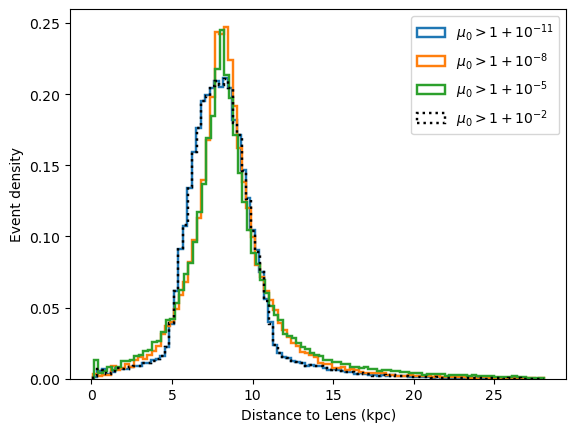

In [74]:
col = 'lens.distance'
unit = u.kpc
data = [
    cut_star[col].to(unit).value,
    cut_bh[col].to(unit).value,
    cut_ns[col].to(unit).value,
]
weights = [
    STELLAR_UNDERSAMPLE*np.ones_like(cut_star[col]),
    GUW_UNDERSAMPLE*np.ones_like(cut_bh[col]),
    GUW_UNDERSAMPLE*np.ones_like(cut_ns[col]),
]
data.append(np.hstack(data))
weights.append(np.hstack(weights))

colours = ['tab:blue', 'tab:orange', 'tab:green', 'k']
# linestyles = ['dotted', 'dashed', 'dashdot', None]
linestyles = [None]*3 + ['dotted']
# labels = ['Stars', 'Black Holes', 'Neutron Stars', 'All']
labels = [f'$\mu_0 > 1 + 10^{{{i}}}$' for i in range(-11, -1, 3)]

for i in range(len(data)):
    plt.hist(data[i], bins=100, histtype='step', weights=weights[i], color=colours[i], 
             ls=linestyles[i], lw=1.75, label=labels[i], density=True)

plt.xlabel('Distance to Lens (kpc)')
plt.ylabel('Event density')
plt.legend();



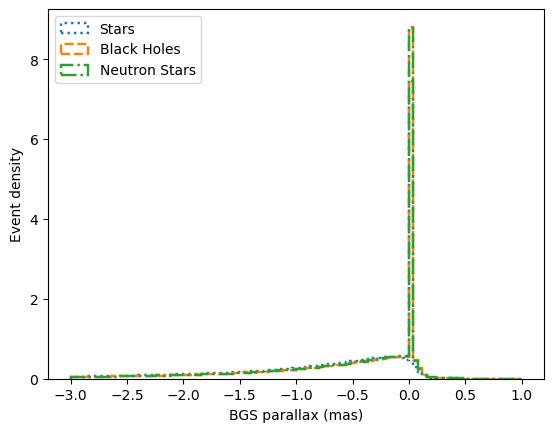

In [75]:
# BGS parallax
col = 'bgs.parallax'
unit = u.mas
data = [
    cut_star[col].to(unit).value,
    cut_bh[col].to(unit).value,
    cut_ns[col].to(unit).value,
]
weights = [
    STELLAR_UNDERSAMPLE*np.ones_like(cut_star[col]),
    GUW_UNDERSAMPLE*np.ones_like(cut_bh[col]),
    GUW_UNDERSAMPLE*np.ones_like(cut_ns[col]),
]

colours = ['tab:blue', 'tab:orange', 'tab:green', 'k']
linestyles = ['dotted', 'dashed', 'dashdot', None]
labels = ['Stars', 'Black Holes', 'Neutron Stars', 'All']

for i in range(len(data)):
    plt.hist(data[i], bins=100, histtype='step', weights=weights[i], color=colours[i], 
             ls=linestyles[i], lw=1.75, label=labels[i], density=True, range=(-3, 1))

plt.xlabel('BGS parallax (mas)')
plt.ylabel('Event density')
plt.legend(loc='upper left');

In [76]:
print(
    sum(cut_bh['bgs.parallax'] < -1*u.mas),
    sum((-1*u.mas < cut_bh['bgs.parallax']) & (cut_bh['bgs.parallax'] < 1*u.mas)),
    sum(cut_bh['bgs.parallax'] > 1*u.mas))

74539 213301 34


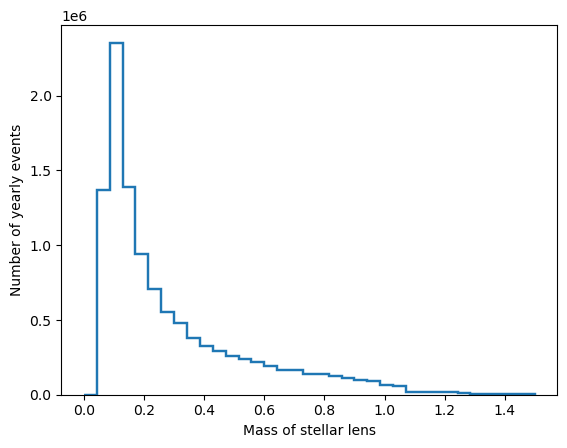

In [77]:
# Make plot of stellar lens masses
col = 'lens.mass'
unit = u.Msun
data = [
    cut_star[col].to(unit).value,
]
weights = [
    STELLAR_UNDERSAMPLE*np.ones_like(cut_star[col]),
]

colours = ['tab:blue', 'tab:orange', 'tab:green', 'k']
labels = ['Stars', 'Black Holes', 'Neutron Stars', 'All']

for i in range(len(data)):
    plt.hist(data[i], bins=35, histtype='step', weights=weights[i], color=colours[i], 
             lw=1.75, range=(0, 1.5))

plt.xlabel('Mass of stellar lens')
plt.ylabel('Number of yearly events');

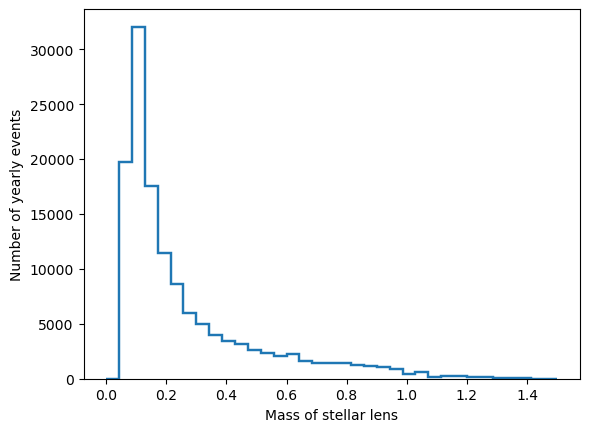

In [78]:
cut_star = mw_table[mw_table['lensing event'].astype(bool)]
cut_star = cut_star[cut_star['lensing magnification'] > 1e-3]

col = 'lens.mass'
unit = u.Msun
data = [
    cut_star[col].to(unit).value,
]
weights = [
    STELLAR_UNDERSAMPLE*np.ones_like(cut_star[col]),
]

colours = ['tab:blue', 'tab:orange', 'tab:green', 'k']
labels = ['Stars', 'Black Holes', 'Neutron Stars', 'All']

for i in range(len(data)):
    plt.hist(data[i], bins=35, histtype='step', weights=weights[i], color=colours[i], 
             lw=1.75, range=(0, 1.5))

plt.xlabel('Mass of stellar lens')
plt.ylabel('Number of yearly events');

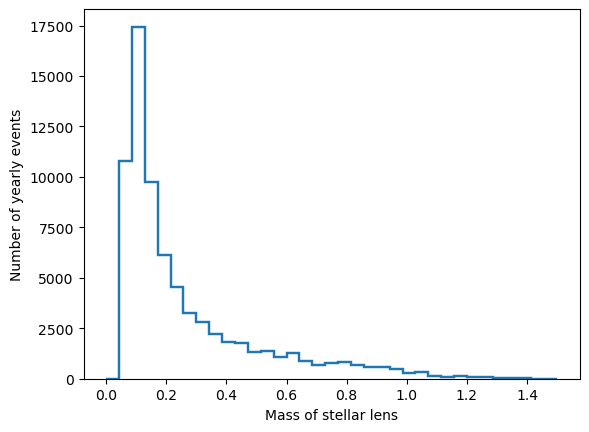

In [79]:
cut_star = mw_table[mw_table['lensing event'].astype(bool)]
cut_star = cut_star[cut_star['lensing magnification'] > 1e-2]

col = 'lens.mass'
unit = u.Msun
data = [
    cut_star[col].to(unit).value,
]
weights = [
    STELLAR_UNDERSAMPLE*np.ones_like(cut_star[col]),
]

colours = ['tab:blue', 'tab:orange', 'tab:green', 'k']
labels = ['Stars', 'Black Holes', 'Neutron Stars', 'All']

for i in range(len(data)):
    plt.hist(data[i], bins=35, histtype='step', weights=weights[i], color=colours[i], 
             lw=1.75, range=(0, 1.5))

plt.xlabel('Mass of stellar lens')
plt.ylabel('Number of yearly events');

# Time Fraction

In [5]:
cut_guw = guw_table[guw_table['lensing event'].astype(bool)]
cut_guw = cut_guw[cut_guw['bump magnitude'] > 1e-10*u.mag]
cut_ns, cut_bh = split_by_type(cut_guw)
cut_star = mw_table[mw_table['lensing event'].astype(bool)]
# bins, bin_centres = get_log_bins(cut_star[col].to(unit).value, 20, max_quantity=6000)
cut_star = cut_star[cut_star['bump magnitude'] > 1e-10*u.mag]

In [ ]:
# BGS parallax
col = 'einstein time'
unit = u.day
data = [
    cut_star[col].to(unit).value,
    cut_bh[col].to(unit).value,
    cut_ns[col].to(unit).value,
]
weights = [
    STELLAR_UNDERSAMPLE*np.ones_like(cut_star[col]),
    GUW_UNDERSAMPLE*np.ones_like(cut_bh[col]),
    GUW_UNDERSAMPLE*np.ones_like(cut_ns[col]),
]
all_data = np.hstack(data)
all_weights = np.hstack(weights)

bins, bin_centres = get_log_bins(cut_star[col].to(unit).value, 20, max_quantity=6000)

all_values = np.histogram(all_data, bins=bins, weights=all_weights)[0]

colours = ['tab:blue', 'tab:orange', 'tab:green']
labels = ['Stars', 'Black Holes', 'Neutron Stars']

for i in range(len(data)):
    values = np.histogram(data[i], bins=bins, weights=weights[i])[0]
    plt.plot(bin_centres, values/all_values, marker='s', lw=1, label=labels[i], c=colours[i])
    print(labels[i], values[-2:])

plt.xlabel('Einstein time (day)')
plt.ylabel('Event Fraction')
plt.legend(loc='upper right')
plt.xscale('log')

photo_fraction = np.histogram(data[1], bins=bins, weights=weights[1])[0]/all_values;

In [6]:
sum(cut_bh['einstein time'] > 1e3*u.day)*GUW_UNDERSAMPLE / (sum(cut_star['einstein time'] > 1e3*u.day)*STELLAR_UNDERSAMPLE)

0.27804070253303

In [71]:
cut_guw = guw_table[guw_table['lensing event'].astype(bool)]
cut_guw = cut_guw[cut_guw['centroid shift'] > 2e-3*u.mas]
cut_ns, cut_bh = split_by_type(cut_guw)
cut_star = mw_table[mw_table['lensing event'].astype(bool)]
cut_star = cut_star[cut_star['centroid shift'] > 2e-3*u.mas]

[3192.4384877   989.49789958  289.9579916 ]
[8083.25083284 2113.72474098  625.66573196]


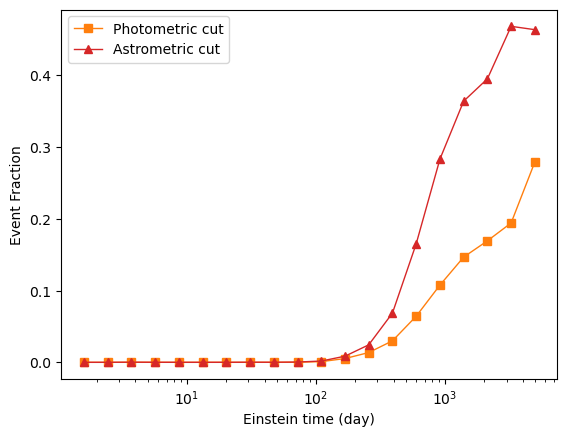

In [72]:
# BGS parallax
col = 'einstein time'
unit = u.day
data = [
    cut_star[col].to(unit).value,
    cut_bh[col].to(unit).value,
    cut_ns[col].to(unit).value,
]
weights = [
    STELLAR_UNDERSAMPLE*np.ones_like(cut_star[col]).to(unit).value,
    GUW_UNDERSAMPLE*np.ones_like(cut_bh[col]).to(unit).value,
    GUW_UNDERSAMPLE*np.ones_like(cut_ns[col]).to(unit).value,
]
all_data = np.hstack(data)
all_weights = np.hstack(weights)

all_values = np.histogram(all_data, bins=bins, weights=all_weights)[0]
bh_values = np.histogram(data[1], bins=bins, weights=weights[1])[0]
astro_fraction = bh_values/all_values

plt.plot(bin_centres, photo_fraction, marker='s', lw=1, label='Photometric cut', c='tab:orange')
plt.plot(bin_centres, astro_fraction, marker='^', lw=1, label='Astrometric cut', c='tab:red')

plt.xlabel('Einstein time (day)')
plt.ylabel('Event Fraction')
plt.legend(loc='upper left')
plt.xscale('log')

print(bh_values[-3:])
print(all_values[-3:]);

# Bulge and Non-Bulge 
## Time Fraction

In [43]:
def get_popsycle_BH_fraction():
    popsycle = pd.read_csv('../Popsycle Digitisation.csv', sep=', ', header=None, names=('Einstein times', 'Fraction', None, 'Species'))

    stars = popsycle.query('Species == "Star"')
    wd = popsycle.query('Species == "WD"')
    ns = popsycle.query('Species == "NS"')
    bh = popsycle.query('Species == "BH"').copy()

    normalising_factor = 1/(stars['Fraction'].to_numpy() + ns['Fraction'].to_numpy() + bh['Fraction'].to_numpy())
    bh['Fraction'] = bh['Fraction']*normalising_factor
    
    return bh

def split_by_bulge(table):
    sc = SkyCoord(ra=table['bgs.ra'], dec=table['bgs.dec'], frame='icrs').transform_to(Galactic)
    
    ls = sc.l
    ls[ls > 180*u.deg] -= 360*u.deg
    table['bgs.l'] = ls
    table['bgs.b'] = sc.b
    
    bulge_indices = ((np.abs(table['bgs.b']) < 10*u.deg)
                     & (np.abs(table['bgs.l']) < 30*u.deg))
        
    bulge = table[bulge_indices]
    non_bulge = table[~bulge_indices]
    
    return bulge, non_bulge

/tmp/ipykernel_21132/2834996412.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  popsycle = pd.read_csv('../Popsycle Digitisation.csv', sep=', ', header=None, names=('Einstein times', 'Fraction', None, 'Species'))


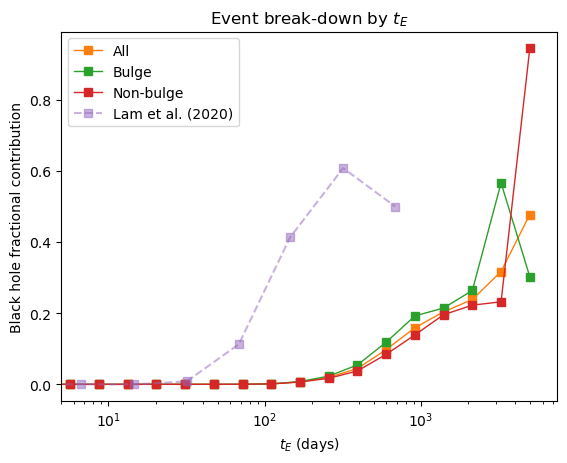

In [53]:
bright_threshold = 1e-10*u.mag

events = guw_table[guw_table['lensing event'].astype(bool)]
NS_events, BH_events = split_by_type(events)
bright_events = events[events['bump magnitude'] > bright_threshold]
NS_bright, BH_bright = split_by_type(bright_events)

star_events = mw_table[mw_table['lensing event'].astype(bool)]
star_bright_events = star_events[star_events['bump magnitude'] > bright_threshold]

star_colour = 'tab:blue'
BH_colour = 'tab:orange'
NS_colour = 'tab:green'

all_events = vstack((star_bright_events, bright_events))
all_events['weight'] = np.concatenate((STELLAR_UNDERSAMPLE*np.ones_like(star_bright_events['einstein time']),
                                    np.ones_like(bright_events['einstein time'])*GUW_UNDERSAMPLE))

left_bound = 5
num_bins = 20

bins, bin_centres = get_log_bins(
    star_bright_events['einstein time'].to(u.day).value, num_bins, max_quantity=6e3)

data = [all_events, BH_bright]

# Separate out the bulge and non-bulge events
bulge_events = []
non_bulge_events = []
for i in range(len(data)):
    bulge, non_bulge = split_by_bulge(data[i])
    bulge_events.append(bulge)
    non_bulge_events.append(non_bulge)

# Create histograms for each set of events and plot them on the same plot
labels = ['All', 'Bulge', 'Non-bulge']
colours = [BH_colour, 'tab:green', 'tab:red']

plt.figure()
for i, datasets in enumerate([data, bulge_events, non_bulge_events]):
    all_values, _ = np.histogram(datasets[0]['einstein time'].to(u.day).value, bins=bins, weights=datasets[0]['weight'])
    BH_values, _ = np.histogram(datasets[1]['einstein time'].to(u.day).value, bins=bins, weights=np.ones_like(datasets[1]['einstein time'])*GUW_UNDERSAMPLE)
    plt.plot(bin_centres, BH_values/all_values, color=colours[i], marker='s', linewidth=1, label=labels[i])

    
popsycle = get_popsycle_BH_fraction()
plt.plot(popsycle['Einstein times'], popsycle['Fraction'], alpha=0.5, ls='--', 
         marker='s', markersize=6, color='tab:purple', label='Lam et al. (2020)')

plt.xscale('log')
plt.xlabel('$t_E$ (days)')
plt.ylabel('Black hole fractional contribution')
plt.title('Event break-down by $t_E$')
plt.xlim(left=left_bound)
plt.legend()

## Wyrzykowski time comparison

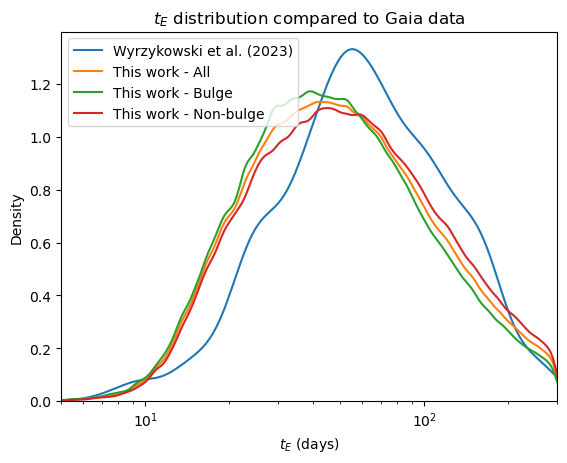

In [51]:
# Load Wyrzykowski's 2023 Gaia data
wyr_table = QTable.read('../Data/Combined-Wyrzykowski.ecsv')

data_labels = ['Wyrzykowski et al. (2023)', 'This work']
bandwidths = [0.75, 1]

bright_threshold = 1e-10*u.mag

events = guw_table[guw_table['lensing event'].astype(bool)]
NS_events, BH_events = split_by_type(events)
bright_events = events[events['bump magnitude'] > bright_threshold]
NS_bright, BH_bright = split_by_type(bright_events)

star_events = mw_table[mw_table['lensing event'].astype(bool)]
star_bright_events = star_events[star_events['bump magnitude'] > bright_threshold]

star_bulge, star_non_bulge = split_by_bulge(star_bright_events)
guw_bulge, guw_non_bulge = split_by_bulge(bright_events)

stellar_t_E = star_bulge['einstein time'].to(u.d).value
bulge_events = np.concatenate((np.repeat(stellar_t_E, STELLAR_UNDERSAMPLE),
                               guw_bulge['einstein time'].to(u.d).value))
stellar_t_E = star_non_bulge['einstein time'].to(u.d).value
non_bulge_events = np.concatenate((np.repeat(stellar_t_E, STELLAR_UNDERSAMPLE), 
                                   guw_non_bulge['einstein time'].to(u.d).value))
stellar_t_E = star_bright_events['einstein time'].to(u.d).value
all_events = np.concatenate((np.repeat(stellar_t_E, STELLAR_UNDERSAMPLE), 
                             bright_events['einstein time'].to(u.d).value))

data = [wyr_table['paczynski1_te'].to(u.d).value, 
        all_events,
        bulge_events, 
        non_bulge_events,
        ]

bounds = [5, 300]
quantity_label = '$t_E$ (days)'
title = '$t_E$ distribution compared to Gaia data'
log_scale = True
data_labels = ['Wyrzykowski et al. (2023)', 'This work - All', 'This work - Bulge', 'This work - Non-bulge']
bandwidths = [0.75, 1, 1, 1]


plt.figure()

for i in range(len(data)):
    data[i] = data[i][(bounds[0] <= data[i]) & (data[i] <= bounds[1])]
    sns.kdeplot(data[i], bw_adjust=bandwidths[i], log_scale=log_scale)

plt.legend(data_labels, loc='upper left')
plt.xlabel(quantity_label)
plt.ylabel('Density')
plt.xlim(bounds)

plt.title(title);

# Shifts and Magnifications Linearity

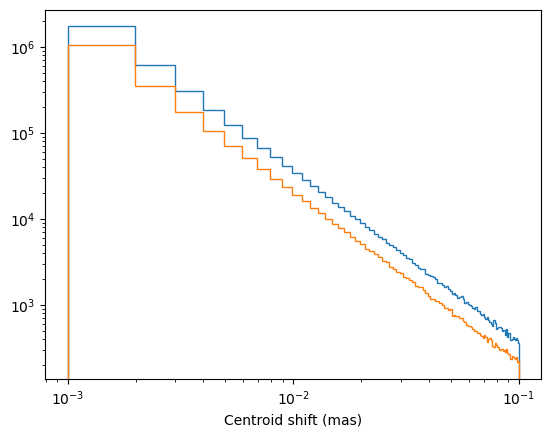

In [12]:
plt.hist(guw_table['centroid shift'].to(u.mas).value, bins=100, range=(1e-3, 0.1), histtype='step')
plt.hist(mw_table['centroid shift'].to(u.mas).value, bins=100, range=(1e-3, 0.1), histtype='step')
plt.xlabel('Centroid shift (mas)')
plt.xscale('log')
plt.yscale('log');

# Position Angle

In [3]:
from calculate_incidence import move_point

In [49]:
def get_earth(ts):
    """
    Get the position of the earth in barycentric coordinates.
    
    The position is calculated using an ellipse which I
    fitted from the 2013 positions of the Astropy get_sun() 
    function. The ellipse repeats every year.
    
    Parameters
    ----------
    ts : numpy array
        Array containing the times in days to get the Earth's position
    
    Returns
    -------
    numpy array
        Array containing the x, y, z coordinates of the earth in AU.
        Array shape is (3, T) where T is the number of times provided.
    """

    # Convert ts to radians
    ts = ts.reshape(-1, 1)*2*np.pi/365.25
    
    # Predefined orbital parameters
    f0 = np.array([0.00559436, -0.02239685, -0.00970921])
    f1 = np.array([-0.18424293, 0.90164277, 0.39087722])
    f2 = np.array([-0.98273009, -0.16903882, -0.07328005])
    
    positions = f0 + f1*np.cos(ts) + f2*np.sin(ts)
    
    return positions.T

def move_point(p, t, parallax=None):
    """
    Move a point according to its proper motion
    
    Parameters
    ----------
    p : numpy array
        Array containing the ra (in degrees), dec (in degrees), 
        pm_ra (in mas/yr), pm_dec (in mas/yr) of the point
    t : float
        Time in days
    parallax : float (optional)
        Parallax of the point in mas. If specified then the point
        will also be moved according to its parallax.
    
    Returns
    -------
    numpy array
        Array containing the ra (in degrees), dec (in degrees), 
        pm_ra (in mas/yr), pm_dec (in mas/yr) of the point after motion
    """
    
    # Convert t to years
    t = t/365.25
    
    # Define declinations in degrees
    dec = p[1] + p[3]/(1000*60*60)*t
    
    # Define right ascensions in degrees
    ra = p[0] + p[2]/(1000*60*60)*t
    
     # Calculate parallax if specified
    if parallax is not None:
        
        # Convert parallax from mas to radians
        parallax = np.radians(parallax/(1000*60*60))
        
        # Convert RA and Dec to radians
        ra = np.radians(ra)
        dec = np.radians(dec)
        
        # Get Earth positions
        x, y, z = get_earth(np.array(t)*365.25)[:, 0]

        # This parallax correction comes from the Kovalevsky & Seidelmann (2004) textbook
        d_dec = parallax*((x*np.cos(ra)+y*np.sin(ra))*np.sin(dec) - z*np.cos(dec))
        d_ra = parallax/np.cos(dec) * (x*np.sin(ra)-y*np.cos(ra))
        
        # Apply parallax
        dec = dec - d_dec
        ra = ra - d_ra
        
        # Convert RA and Dec back to degrees
        ra = np.degrees(ra)
        dec = np.degrees(dec)
    
    # Check if motion has gone over the poles (+- 90 deg)
    # if abs(dec) > 90:
        # assert abs(dec) < 180
        # Pole correction
        correction = np.clip(2*(abs(dec) - 90), 0, None)
        dec = dec - np.sign(dec)*correction
        ra = (ra + 180*(correction != 0)) % 360

    new = np.array((ra, dec, p[2], p[3]))
    
    return new

def move_year_before_event(table):
    start_time = Time(table.meta['Start time'])
    year_before_event = (table['event time'].jd - start_time.jd - 365.25)/365.25
    lens = (table['lens.ra'].to(u.deg).value, 
            table['lens.dec'].to(u.deg).value,
            table['lens.pmra'].to(u.mas/u.yr).value,
            table['lens.pmdec'].to(u.mas/u.yr).value)
    lens_parallax = table['lens.distance'].to(u.mas, u.parallax()).value
    lens = move_point(lens, year_before_event, parallax=1.01*lens_parallax)
    table['lens.ra'] = lens[0]*u.deg
    table['lens.dec'] = lens[1]*u.deg
    
    bgs = (table['bgs.ra'].to(u.deg).value, 
            table['bgs.dec'].to(u.deg).value,
            table['bgs.pmra'].to(u.mas/u.yr).value,
            table['bgs.pmdec'].to(u.mas/u.yr).value)
    bgs_parallax = table['bgs.parallax'].to(u.mas).value
    bgs = move_point(bgs, year_before_event, parallax=1.01*bgs_parallax)
    table['bgs.ra'] = bgs[0]*u.deg
    table['bgs.dec'] = bgs[1]*u.deg

    return table

In [4]:
bright_threshold = 1e-10*u.mag

GUW_bright = guw_table[guw_table['bump magnitude'] > bright_threshold]
NS_bright, BH_bright = split_by_type(GUW_bright)
star_bright_events = mw_table[mw_table['bump magnitude'] > bright_threshold]

NS_bright = move_year_before_event(NS_bright)
BH_bright = move_year_before_event(BH_bright)
star_bright_events = move_year_before_event(star_bright_events)


NameError: name 'move_year_before_event' is not defined

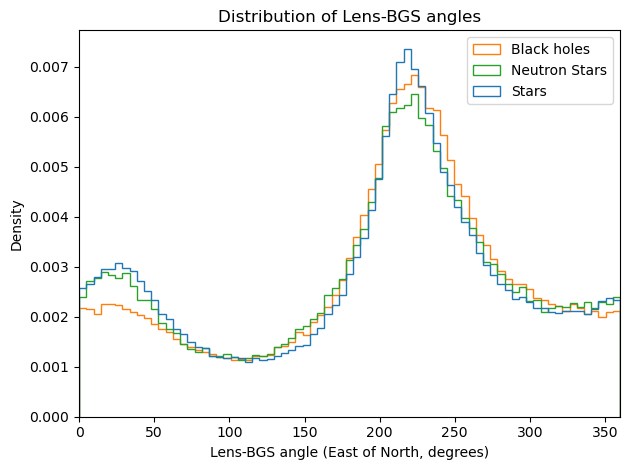

In [5]:
BH_colour, NS_colour, star_colour = 'tab:orange', 'tab:green', 'tab:blue'

num_bins = 75

plt.figure()
for events, label, colour in zip([BH_bright, NS_bright, star_bright_events], 
                                 ['Black holes', 'Neutron Stars', 'Stars'],
                                 [BH_colour, NS_colour, star_colour]):
    pos_angles = coords.position_angle(events['lens.ra'], events['lens.dec'], 
                                       events['bgs.ra'], events['bgs.dec'])
    plt.hist(pos_angles.deg, bins=num_bins, range=(0, 360), density=True, histtype='step', label=label, color=colour)
    
plt.title('Distribution of Lens-BGS angles')
plt.xlabel('Lens-BGS angle (East of North, degrees)')
plt.ylabel('Density')
plt.legend()
plt.xlim([0, 360])

plt.tight_layout()
plt.savefig(f'../Plots/{folder_name}/Approach_angle.png')
plt.show()
plt.close()

# GaiaNIR Fraction

In [ ]:
files = ['32_year_Gaia_lensing_results_all_GaiaNIR.ecsv']
files = files + [f'32_year_Gaia_lensing_results+{i}_all_GaiaNIR.ecsv' for i in range(200, 20001, 200)]

astrometric_cuts = np.logspace(-2.7, 0, 100)
photometric_cuts = np.logspace(-6, 2, 100)

all_species = ['Black Holes', 'Neutron Stars']
all_masses = [7.8, 1.35]
astro_fractions = {species: [] for species in all_species}
photo_fractions = {species: [] for species in all_species}

for file in files:
    table = QTable.read('../Data/'+file)
    for species, mass in zip(all_species, all_masses):
        species_table = table[table['lens.mass'] == mass*u.Msun]
        all = len(unique(species_table, keys=['lens.ra', 'lens.dec']))
        fractions = []
        for cut in astrometric_cuts:
            cut_table = species_table[species_table['centroid shift'] >= cut*u.mas]
            if len(cut_table) == 0:
                cut_num = 0
            else:
                cut_num = len(unique(cut_table, keys=['lens.ra', 'lens.dec']))
            fractions.append(cut_num/all)
    
        astro_fractions[species].append(fractions)
        fractions = []
        for cut in photometric_cuts:
            cut_table = species_table[species_table['lensing magnification'] >= cut]
            if len(cut_table) == 0:
                cut_num = 0
            else:
                cut_num = len(unique(cut_table, keys=['lens.ra', 'lens.dec']))
            fractions.append(cut_num/all)
        photo_fractions[species].append(fractions)       


In [ ]:
plt.figure()
for species in all_species:
    plt.plot(astrometric_cuts, np.mean(astro_fractions[species], axis=0), label=species)
plt.xscale('log')
plt.xlabel('Centroid shift (mas)')
plt.ylabel('Fraction of population')
plt.title('Astrometric cuts')
plt.legend()
plt.tight_layout()
plt.savefig(f'../Plots/32_year_Gaia_x{len(files)}_all/Astrometric_lensing_fraction.png')
plt.show()
plt.close()


plt.figure()
for species in all_species:
    plt.plot(photometric_cuts, np.mean(photo_fractions[species], axis=0), label=species)
plt.xscale('log')
plt.xlabel('Magnification - 1')
plt.ylabel('Fraction of population')
plt.title('Photometric cuts')
plt.legend()
plt.tight_layout()
plt.savefig(f'../Plots/32_year_Gaia_x{len(files)}_all/Photometric_lensing_fraction.png')
plt.show()
plt.close();

# Microlens Parallax Scatter

In [5]:
bright_threshold = 4
bright_events = guw_table[guw_table['lensing magnification'] > bright_threshold]
NS_bright, BH_bright = split_by_type(bright_events)
star_bright_events = mw_table[mw_table['lensing magnification'] > bright_threshold]

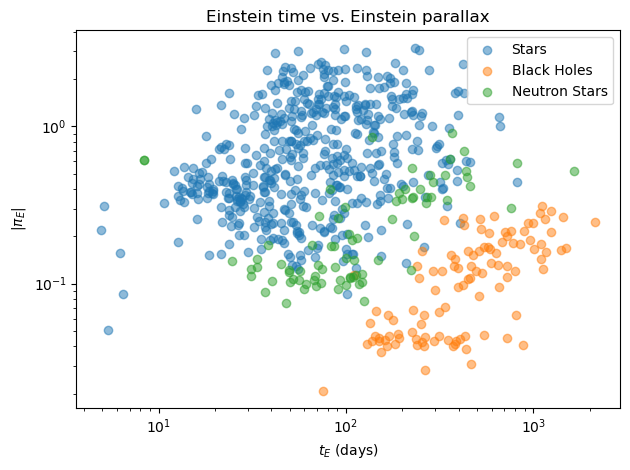

In [8]:
plt.figure()

for data in [star_bright_events, BH_bright, NS_bright]:
    lens_parallax = (1/(data['lens.distance'].to(u.pc).value)) * u.arcsec
    # pi_E = pi_rel / theta_E
    einstein_parallax = np.abs(lens_parallax - data['bgs.parallax'])/data['einstein angle']
    plt.scatter(data['einstein time'].to(u.day).value, einstein_parallax.decompose(), alpha=0.5)

plt.title('Einstein time vs. Einstein parallax')
plt.xlabel('$t_E$ (days)')
plt.ylabel('$|\\pi_E|$')
plt.legend(['Stars', 'Black Holes', 'Neutron Stars'])
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()

# Simulation Depiction

In [60]:
from IPython import display
import matplotlib as mpl

In [14]:
def get_earth(ts):
    """
    Get the position of the earth in barycentric coordinates.
    
    The position is calculated using an ellipse which I
    fitted from the 2013 positions of the Astropy get_sun() 
    function. The ellipse repeats every year.
    
    Parameters
    ----------
    ts : numpy array
        Array containing the times in days to get the Earth's position
    
    Returns
    -------
    numpy array
        Array containing the x, y, z coordinates of the earth in AU.
        Array shape is (3, T) where T is the number of times provided.
    """

    # Convert ts to radians
    ts = ts.reshape(-1, 1)*2*np.pi/365.25
    
    # Predefined orbital parameters
    f0 = np.array([0.00559436, -0.02239685, -0.00970921])
    f1 = np.array([-0.18424293, 0.90164277, 0.39087722])
    f2 = np.array([-0.98273009, -0.16903882, -0.07328005])
    
    positions = f0 + f1*np.cos(ts) + f2*np.sin(ts)
    
    return positions.T

def move_point(p, t, parallax=None):
    """
    Move a point according to its proper motion
    
    Parameters
    ----------
    p : numpy array
        Array containing the ra (in degrees), dec (in degrees), 
        pm_ra (in mas/yr), pm_dec (in mas/yr) of the point
    t : float
        Time in days
    parallax : float (optional)
        Parallax of the point in mas. If specified then the point
        will also be moved according to its parallax.
    
    Returns
    -------
    numpy array
        Array containing the ra (in degrees), dec (in degrees), 
        pm_ra (in mas/yr), pm_dec (in mas/yr) of the point after motion
    """
    
    # Convert t to years
    t = t/365.25
    
    # Define declinations in degrees
    dec = p[1] + p[3]/(1000*60*60)*t
    
    # Define right ascensions in degrees
    ra = p[0] + p[2]/(1000*60*60)*t
    
     # Calculate parallax if specified
    if parallax is not None:
        
        # Convert parallax from mas to radians
        parallax = np.radians(parallax/(1000*60*60))
        
        # Convert RA and Dec to radians
        ra = np.radians(ra)
        dec = np.radians(dec)
        
        # Get Earth positions
        x, y, z = get_earth(np.array(t)*365.25)
        
        # This parallax correction comes from the Kovalevsky & Seidelmann (2004) textbook
        d_dec = parallax*((x*np.cos(ra)+y*np.sin(ra))*np.sin(dec) - z*np.cos(dec))
        d_ra = parallax/np.cos(dec) * (x*np.sin(ra)-y*np.cos(ra))
        
        # Apply parallax
        dec = dec - d_dec
        ra = ra - d_ra
        
        # Convert RA and Dec back to degrees
        ra = np.degrees(ra)[0]
        dec = np.degrees(dec)[0]
    
    # Check if motion has gone over the poles (+- 90 deg)
    if abs(dec) > 90:
        assert abs(dec) < 180
        # Pole correction
        correction = np.clip(2*(abs(dec) - 90), 0, None)
        dec = dec - np.sign(dec)*correction
        ra = (ra + 180*(correction != 0)) % 360
    
    new = np.array((ra, dec, p[2], p[3]))
    
    return new

In [30]:
point = np.array([45., 45., -2., -2.])
ras, decs = [], []

for i in range(10*365):
    moved_point = move_point(point, i, parallax=1.)
    ras.append(moved_point[0])
    decs.append(moved_point[1])
    
ras = np.array(ras)
decs = np.array(decs)

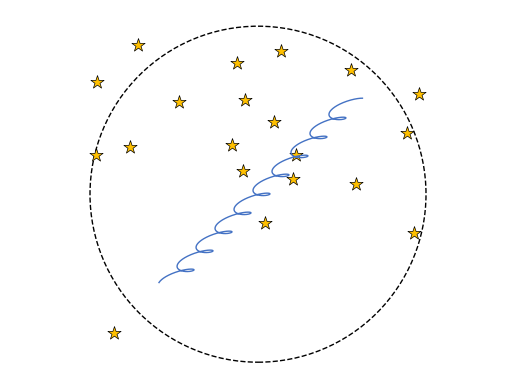

In [78]:
start = 60
end = -150

stored = []
for i in range(1):
    plt.figure()
    plt.plot(ras[start:end], decs[start:end], color='#4472C4', lw=1)
    plt.axis('off')
    plt.axis('equal')
    
    centre = np.array((np.median(ras), np.median(decs)))
    radius = 1.75*(np.max(decs)-np.median(decs))
    
    circle = mpl.patches.Circle(centre, radius=radius,
                                fill=False, ls='--')
    plt.gca().add_patch(circle)


    np.random.seed(i)
    stars = np.random.uniform(centre-radius, centre+radius, size=(20, 2))
    plt.scatter(stars[:, 0], stars[:, 1], marker='*', s=100, c='#FFC000', lw=0.5, ec='k')
    plt.show()
    plt.close()
#     val = input('')
#     if val != '':
#         stored.append(i)
#     display.clear_output(wait=True)



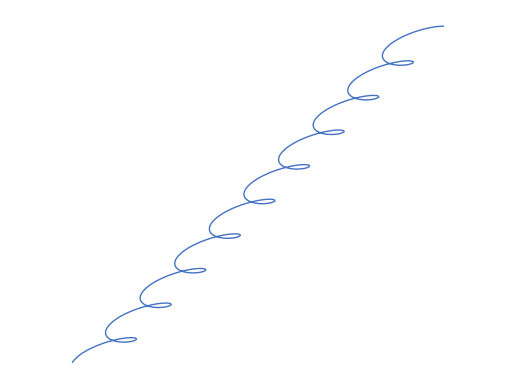

In [77]:
plt.figure()
plt.plot(ras[start:end], decs[start:end], lw=1, color='#4472C4')
plt.axis('off')
plt.axis('equal')
plt.savefig('../Parallax Trace.png', dpi=512, transparent=True)

# Comparison to Popsycle

In [50]:
values = pd.read_csv('../Popsycle Digitisation.csv', sep=', ', header=None, names=('Einstein times', 'Fraction', None, 'Species'))
values.head()

/tmp/ipykernel_6928/880453519.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  values = pd.read_csv('../Popsycle Digitisation.csv', sep=', ', header=None, names=('Einstein times', 'Fraction', None, 'Species'))


Einstein times  Fraction  None Species
0        1.463046  1.000000     0    Star
1        3.155229  0.982609     1    Star
2        6.716558  0.960870     2    Star
3       14.674960  0.891304     3    Star
4       31.648267  0.756522     4    Star

In [51]:
stars = values.query('Species == "Star"')
wd = values.query('Species == "WD"')
ns = values.query('Species == "NS"')
bh = values.query('Species == "BH"')

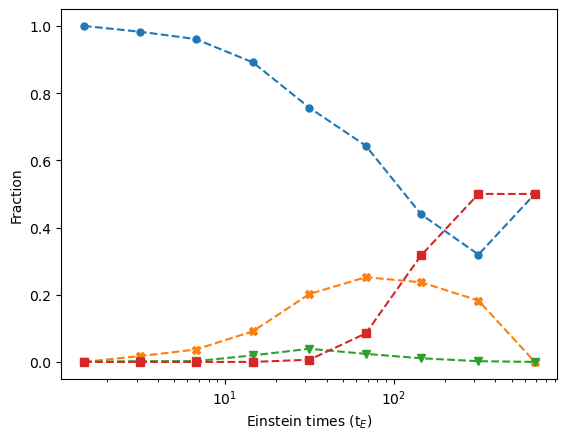

In [85]:
plt.plot(stars['Einstein times'], stars['Fraction'], ls='--', marker='.', markersize=10, color='tab:blue')
plt.plot(wd['Einstein times'], wd['Fraction'], ls='--', marker='X', color='tab:orange')
plt.plot(ns['Einstein times'], ns['Fraction'], ls='--', marker='v', color='tab:green')
plt.plot(bh['Einstein times'], bh['Fraction'], ls='--', marker='s', color='tab:red')
plt.xlabel('Einstein times (t$_E$)')
plt.ylabel('Fraction')
plt.xscale('log');


In [101]:
normalising_factor = 1/(stars['Fraction'].to_numpy() + ns['Fraction'].to_numpy() + bh['Fraction'].to_numpy())
normalising_factor

array([1.        , 1.01545254, 1.03837472, 1.09785203, 1.24661247,
       1.32947977, 1.30311615, 1.21693122, 1.        ])

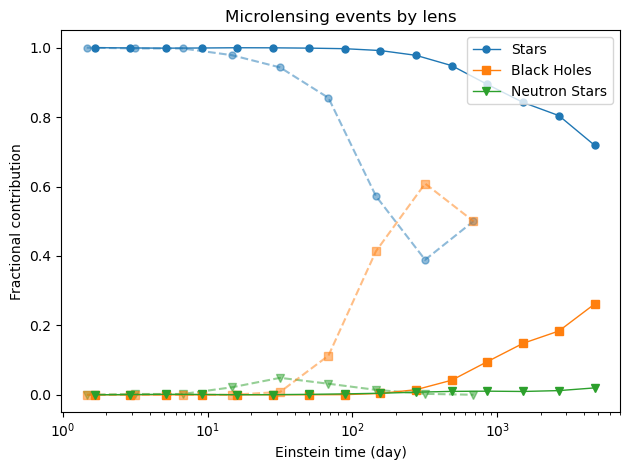

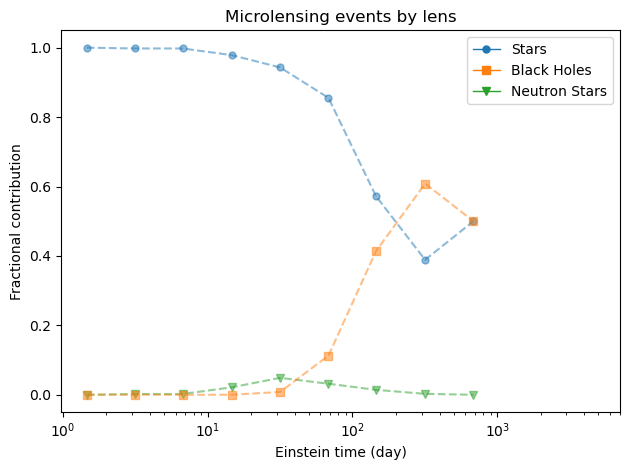

In [128]:
colours = ['tab:blue', 'tab:orange', 'tab:green']
labels = ['Stars', 'Black Holes', 'Neutron Stars']
markers = ['.', 's', 'v']
marker_sizes = [10, 6, 6]

plt.figure()

plt.plot(stars['Einstein times'], stars['Fraction']*normalising_factor, alpha=0.5, ls='--', 
         marker='.', markersize=10, color='tab:blue')
plt.plot(ns['Einstein times'], ns['Fraction']*normalising_factor, alpha=0.5, ls='--', 
         marker='v', markersize=6, color='tab:green')
plt.plot(bh['Einstein times'], bh['Fraction']*normalising_factor, alpha=0.5, ls='--', 
         marker='s', markersize=6, color='tab:orange')

for i in range(len(data)):
    values = np.histogram(data[i], bins=bins, weights=weights[i])[0]
    plt.plot(bin_centres, values/all_values, marker=markers[i], markersize=marker_sizes[i], 
             lw=1, label=labels[i], c=colours[i])

plt.xlabel('Einstein time (day)')
plt.ylabel('Fractional contribution')
plt.title('Microlensing events by lens')
plt.legend(loc='upper right')
plt.xscale('log')
plt.tight_layout()
locs, lab = plt.xlim()
plt.savefig('../Event_fraction_all.png', dpi=512);


plt.figure()

plt.plot(stars['Einstein times'], stars['Fraction']*normalising_factor, alpha=0.5, ls='--', 
         marker='.', markersize=10, color='tab:blue')
plt.plot(ns['Einstein times'], ns['Fraction']*normalising_factor, alpha=0.5, ls='--', 
         marker='v', markersize=6, color='tab:green')
plt.plot(bh['Einstein times'], bh['Fraction']*normalising_factor, alpha=0.5, ls='--', 
         marker='s', markersize=6, color='tab:orange')

for i in range(len(data)):
    values = np.histogram(data[i], bins=bins, weights=weights[i])[0]
    plt.plot(np.array(bin_centres)+10000, values/all_values, marker=markers[i], markersize=marker_sizes[i], 
             lw=1, label=labels[i], c=colours[i])

plt.xlabel('Einstein time (day)')
plt.ylabel('Fractional contribution')
plt.title('Microlensing events by lens')
plt.legend(loc='upper right')
plt.xscale('log')
plt.xlim(locs, lab)
plt.tight_layout()
plt.savefig('../Event_fraction_Lam.png', dpi=512);

In [99]:
normalising_factor

array([1.        , 1.01545254, 1.03837472, 1.09785203, 1.24661247,
       1.32947977, 1.30311615, 1.21693122, 1.        ])

In [106]:
stars['Fraction']*normalising_factor + ns['Fraction']*normalising_factor + bh['Fraction']*normalising_factor

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Bump Magnitudes

/tmp/ipykernel_6928/836764283.py:65: UserWarning: Minimum quantity is less than 2e-16, setting to 2e-16.
  warnings.warn('Minimum quantity is less than 2e-16, setting to 2e-16.')


(2.5913558287964524, 872628.0)

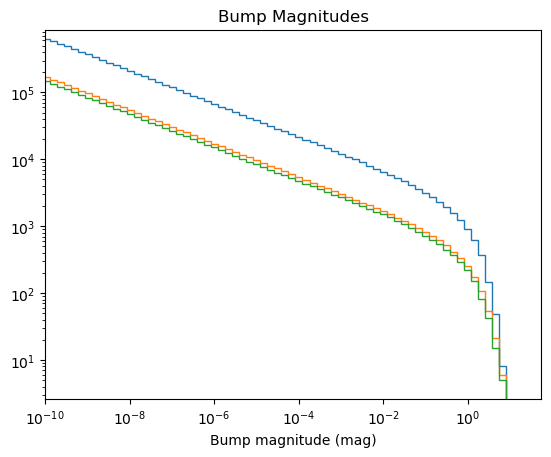

In [170]:
events = guw_table[guw_table['lensing event'].astype(bool)]
NS_events, BH_events = split_by_type(events)
star_events = mw_table[mw_table['lensing event'].astype(bool)]

bh_data = BH_events['bump magnitude'].to(u.mag).value
ns_data = NS_events['bump magnitude'].to(u.mag).value
star_data = star_events['bump magnitude'].to(u.mag).value


title = 'Bump Magnitudes'
x_label = 'Bump magnitude (mag)'
cumulative = -1
left_bound = 1e-10

bins, bin_centres = get_log_bins(star_data, 100)
smallest_bin_index = sum(bins < left_bound)

vals, _, _ = plt.hist(star_data, bins=bins, histtype='step', cumulative=cumulative)
plt.hist(bh_data, bins=bins, histtype='step', cumulative=cumulative)
plt.hist(ns_data, bins=bins, histtype='step', cumulative=cumulative)
plt.xlabel(x_label)
plt.title(title)
plt.xscale('log')
plt.yscale('log')
plt.xlim(left=left_bound)
plt.ylim(top=1.5*vals[smallest_bin_index])

# Bump Magnitude Event Fraction

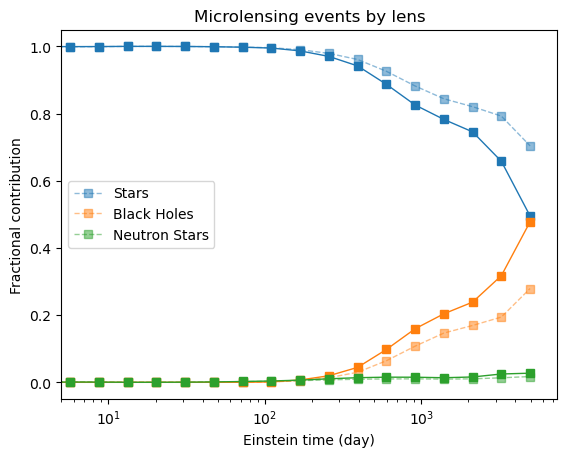

In [175]:
star_colour = 'tab:blue'
BH_colour = 'tab:orange'
NS_colour = 'tab:green'
labels = ['Stars', 'Black Holes', 'Neutron Stars']
markers = ['.', 's', 'v']
marker_sizes = [10, 6, 6]
num_bins = 20

events = guw_table[guw_table['lensing event'].astype(bool)]
NS_events, BH_events = split_by_type(events)
star_events = mw_table[mw_table['lensing event'].astype(bool)]

star_events = star_events[star_events['lensing magnification'] >= 1e-11]
events = events[events['lensing magnification'] >= 1e-11]
NS_events = NS_events[NS_events['lensing magnification'] >= 1e-11]
BH_events = BH_events[BH_events['lensing magnification'] >= 1e-11]

all_events = np.concatenate((star_events['einstein time'].to(u.day).value, 
                            events['einstein time'].to(u.day).value))
all_event_weights = np.concatenate((STELLAR_UNDERSAMPLE*np.ones_like(star_events['einstein time']),
                                    np.ones_like(events['einstein time'])*GUW_UNDERSAMPLE))
bins, bin_centres = get_log_bins(
    star_events['einstein time'].to(u.day).value, num_bins, max_quantity=6e3)

all_values, _ = np.histogram(all_events, bins=bins, weights=all_event_weights)
star_values, _ = np.histogram(star_events['einstein time'].to(u.day).value, 
                              bins=bins, weights=STELLAR_UNDERSAMPLE*np.ones_like(star_events['einstein time']))
BH_values, _ = np.histogram(BH_events['einstein time'].to(u.day).value, bins=bins, weights=np.ones_like(BH_events['einstein time'])*GUW_UNDERSAMPLE)
NS_values, _ = np.histogram(NS_events['einstein time'].to(u.day).value, bins=bins, weights=np.ones_like(NS_events['einstein time'])*GUW_UNDERSAMPLE)

plt.figure()

plt.plot(bin_centres, star_values/all_values, '--', alpha=0.5, marker='s', linewidth=1, label='Stars', c=star_colour)
plt.plot(bin_centres, BH_values/all_values, '--', alpha=0.5, marker='s', linewidth=1, label='Black Holes', c=BH_colour)
plt.plot(bin_centres, NS_values/all_values, '--', alpha=0.5, marker='s', linewidth=1, label='Neutron Stars', c=NS_colour)
plt.xscale('log')
plt.xlabel('Einstein time (day)')
plt.ylabel('Fractional contribution')
plt.title('Microlensing events by lens')
plt.xlim(left=5)
plt.legend()




events = guw_table[guw_table['lensing event'].astype(bool)]
NS_events, BH_events = split_by_type(events)
star_events = mw_table[mw_table['lensing event'].astype(bool)]

star_events = star_events[star_events['bump magnitude'] >= 1e-10*u.mag]
events = events[events['bump magnitude'] >= 1e-10*u.mag]
NS_events = NS_events[NS_events['bump magnitude'] >= 1e-10*u.mag]
BH_events = BH_events[BH_events['bump magnitude'] >= 1e-10*u.mag]

all_events = np.concatenate((star_events['einstein time'].to(u.day).value, 
                            events['einstein time'].to(u.day).value))
all_event_weights = np.concatenate((STELLAR_UNDERSAMPLE*np.ones_like(star_events['einstein time']),
                                    np.ones_like(events['einstein time'])*GUW_UNDERSAMPLE))
bins, bin_centres = get_log_bins(
    star_events['einstein time'].to(u.day).value, num_bins, max_quantity=6e3)

all_values, _ = np.histogram(all_events, bins=bins, weights=all_event_weights)
star_values, _ = np.histogram(star_events['einstein time'].to(u.day).value, 
                              bins=bins, weights=STELLAR_UNDERSAMPLE*np.ones_like(star_events['einstein time']))
BH_values, _ = np.histogram(BH_events['einstein time'].to(u.day).value, bins=bins, weights=np.ones_like(BH_events['einstein time'])*GUW_UNDERSAMPLE)
NS_values, _ = np.histogram(NS_events['einstein time'].to(u.day).value, bins=bins, weights=np.ones_like(NS_events['einstein time'])*GUW_UNDERSAMPLE)

plt.plot(bin_centres, star_values/all_values, marker='s', linewidth=1, label='Stars', c=star_colour)
plt.plot(bin_centres, BH_values/all_values, marker='s', linewidth=1, label='Black Holes', c=BH_colour)
plt.plot(bin_centres, NS_values/all_values, marker='s', linewidth=1, label='Neutron Stars', c=NS_colour)

# Microlensing Parallax Scatter

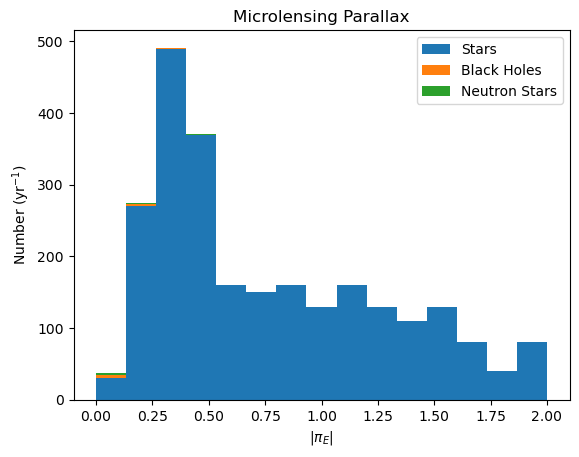

In [55]:
MW_UNDERSAMPLE = 1e6/(1e5-2)
GUW_UNDERSAMPLE = 1e3/(1e4-2)

guw_table['lens.parallax'] = guw_table['lens.distance'].to(u.mas, u.parallax())
guw_table['microlensing parallax'] = abs(guw_table['lens.parallax'] - guw_table['bgs.parallax'])/guw_table['einstein angle']

mw_table['lens.parallax'] = mw_table['lens.distance'].to(u.mas, u.parallax())
mw_table['microlensing parallax'] = abs(mw_table['lens.parallax'] - mw_table['bgs.parallax'])/mw_table['einstein angle']

cut_guw = guw_table[guw_table['bump magnitude'] > 2*u.mag]
cut_mw = mw_table[mw_table['bump magnitude'] > 2*u.mag]

cut_ns, cut_bh = split_by_type(cut_guw)


star_bottom, bins, _ = plt.hist(cut_mw['microlensing parallax'], bins=15, color='tab:blue', range=(0, 2.), label='Stars', 
                         weights=MW_UNDERSAMPLE*np.ones_like(cut_mw['microlensing parallax']))
bh_bottom, _, _ = plt.hist(cut_bh['microlensing parallax'], bins=bins, color='tab:orange', 
                           bottom=star_bottom, 
                           weights=GUW_UNDERSAMPLE*np.ones_like(cut_bh['microlensing parallax']), 
                           label='Black Holes')
plt.hist(cut_ns['microlensing parallax'], bins=bins, color='tab:green', bottom=star_bottom + bh_bottom, 
         weights=GUW_UNDERSAMPLE*np.ones_like(cut_ns['microlensing parallax']), label='Neutron Stars')
plt.xlabel('$|\pi_E|$')
plt.ylabel('Number (yr$^{-1}$)')
plt.title('Microlensing Parallax')
plt.legend();
# plt.savefig('../Plots/10000_year_all_GUW_paper_mag/Microlensing_parallax_histogram.png', dpi=512);
